## 1: Import required packages & functions <a class="anchor" id="chapter1"></a>

In [343]:
print('Importing libraries')

%reset -f

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# clear all variables
for i in list(globals().keys()):
    if(i[0] != '_'):
        exec('del {}'.format(i))

#suppress future warnings -- not really a good idea 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# import required dependencies
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
import csv
import xlrd
import math
from matplotlib import figure
from IPython.display import FileLink, FileLinks
from IPython.display import set_matplotlib_formats

#import utils
#from utils import encode_features_v3

set_matplotlib_formats('png', 'pdf') # uses vector figures in pdf exports --
plt.style.use('seaborn-pastel')

# create a folder
def create_folder(folder):
    import os     
    try: 
        os.mkdir(folder) 
    except FileExistsError:
        print("Directory [ %s ] already exists"%folder)

Importing libraries


In [344]:
create_folder("Classification")

feats = pd.read_csv('../data/Neuropathology Features.csv',header = 0)
master = pd.read_csv('../data/master.csv',header = 0)
patho = master[feats.Features]

selected_features_with_AB = pd.read_csv('Ranking/selected_features_with_AB.csv',header = 0)
selected_features_with_AB = selected_features_with_AB[~selected_features_with_AB['Features'].isin(["age", "brain weight", "HippocTauStage"])]
selected_features_with_AB.reset_index(inplace=True, drop=True)

# drop three features due to high number of missing values
patho.drop(columns=['PARTdefinite', 'PARTall', 'HippocTauStage'], inplace=True)
patho.dropna(inplace=True)


Directory [ Classification ] already exists


In [345]:
cleansed_data = pd.DataFrame()
cleansed_data = patho[selected_features_with_AB.Features]
cleansed_data.insert(loc=0, column='Case', value=patho.Case)
cleansed_data['dem_nver4'] = patho.dem_nver4

data_no_drop_missing_values = cleansed_data.copy()
data_no_drop_missing_values.to_csv(r'Classification/data_no_drop_missing_values.csv',mode = 'w',index=False)

cleansed_data.dropna(inplace=True)
cleansed_data.to_csv(r'Classification/cleansed_data.csv',mode = 'w',index=False)

# count controls and dementia
dementias=cleansed_data.dem_nver4.value_counts()
print('Dementia   : {} \nNo dementia: {}'.format(dementias[0], dementias[1]))
print('Samples    : {} \nFeatures   : {}'.format(cleansed_data.shape[0], cleansed_data.shape[1]))

Dementia   : 89 
No dementia: 57
Samples    : 146 
Features   : 24


## 2: Prepare data for classification   <a class="anchor" id="chapter2"></a>

Since we have imbalanced class label with 89 with Dementia and 57 No dementia, we need to remove 32 samples from the demented patients randomly

In [346]:
cleansed_data['dem_nver4'].value_counts()

Dementia       89
No dementia    57
Name: dem_nver4, dtype: int64

In [348]:
import sklearn

# get demented and non-demented groups
dementia = cleansed_data[cleansed_data.dem_nver4 == 'Dementia']
no_dementia = cleansed_data[cleansed_data.dem_nver4 == 'No dementia']

# select 57 samples from the demented group
selected = dementia.sample(n=57, random_state=0)

# combine both groups togather in a series
frames = [no_dementia, selected]

# shuffle the conbined groups rows and save file
new_balanced = pd.concat(frames)
new_balanced = sklearn.utils.shuffle(new_balanced, random_state=101)
new_balanced.to_csv(r'Classification/new_balanced_weka.csv',mode = 'w',index=False)

# replace string to numeric and save file
new_balanced.dem_nver4.replace({'No dementia':0, 'Dementia':1}, inplace=True)
new_balanced.to_csv(r'Classification/new_balanced.csv',mode = 'w',index=False)

# save the 32 removed samples with and without age and brain weight
common = dementia.merge(selected, on=["Case"])
not_selected = dementia[~dementia.Case.isin(common.Case)]
not_selected.to_csv(r'Classification/not_selected.csv',mode = 'w',index=False)
# not_selected_no_AB = not_selected.drop(columns=['Case'])#, 'age', 'brain weight'])
not_selected.to_csv(r'Classification/not_selected.csv',mode = 'w',index=False)

# drop two features and save file
# new_balanced_no_AB = new_balanced.drop(columns=['Case'])#, 'age', 'brain weight'])
new_balanced_no_AB = new_balanced
new_balanced_no_AB.to_csv(r'Classification/new_balanced_no_AB.csv',mode = 'w',index=False)


# count controls and dementia
# count cluster memberships
dementias=new_balanced_no_AB.dem_nver4.value_counts()
print('new_balanced_no_AB:')
print('Dementia   : {} \nNo dementia: {}'.format(dementias[0], dementias[1]))
print('Samples    : {} \nFeatures   : {}'.format(new_balanced_no_AB.shape[0], new_balanced_no_AB.shape[1]))
print('')


new_balanced_no_AB:
Dementia   : 57 
No dementia: 57
Samples    : 114 
Features   : 24



## 3: Classification   <a class="anchor" id="chapter3"></a>

In [349]:
new_balanced_no_AB = pd.read_csv('Classification/new_balanced_no_AB.csv'); 
new_balanced_no_AB = new_balanced_no_AB.drop(columns=['Case'])
X=new_balanced_no_AB.drop(columns=['dem_nver4']); y=new_balanced_no_AB['dem_nver4']

In [350]:
'''  function to calculate all measures'''

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


def perf_eval(actual, predicted):
    # calculate confusion matrix
    cm=confusion_matrix(actual, predicted)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
#     TP,FN,FP,TN = confusion_matrix(actual, predicted)#, labels=[1, 0]).reshape(-1)

    # calculate perf
    sens=(TP/(TP+FN))
    spec=(TN/(TN+FP))
    acc=((TP+TN)/(TP+FP+TN+FN))

    precision = TP / (TP+FP)
    recall    = TP / (TP+FN)

    F1_score = 2 * (precision * recall) / (precision + recall)
    
    fpr, tpr, thresholds = metrics.roc_curve(actual, predicted)
    auc_value = metrics.auc(fpr, tpr)
    
    return sens, spec, auc_value

In [351]:
'''logreg'''
logreg_fscore_mean=[]; logreg_precision_mean=[]; logreg_balanced_acc_mean=[]
logreg_sens_mean=[]; logreg_spec_mean=[]; logreg_acc_mean=[]; logreg_average_precision_mean=[]; logreg_auc_mean=[];

logreg_rev_fscore_mean=[]; logreg_rev_precision_mean=[]; logreg_rev_balanced_acc_mean=[];
logreg_rev_sens_mean=[]; logreg_rev_spec_mean=[]; logreg_rev_acc_mean=[]; logreg_rev_average_precision_mean=[]; logreg_rev_auc_mean=[]

'''dt'''
dt_fscore_mean=[]; dt_precision_mean=[]; dt_balanced_acc_mean=[]
dt_sens_mean=[]; dt_spec_mean=[]; dt_acc_mean=[]; dt_average_precision_mean=[]; dt_auc_mean=[]

dt_rev_fscore_mean=[]; dt_rev_precision_mean=[]; dt_rev_balanced_acc_mean=[]
dt_rev_sens_mean=[]; dt_rev_spec_mean=[]; dt_rev_acc_mean=[]; dt_rev_average_precision_mean=[]; dt_rev_auc_mean=[]

'''knn'''
knn_fscore_mean=[]; knn_precision_mean=[]; knn_balanced_acc_mean=[]
knn_sens_mean=[]; knn_spec_mean=[]; knn_acc_mean=[]; knn_average_precision_mean=[]; knn_auc_mean=[]

knn_rev_fscore_mean=[]; knn_rev_precision_mean=[]; knn_rev_balanced_acc_mean=[]
knn_rev_sens_mean=[]; knn_rev_spec_mean=[]; knn_rev_acc_mean=[]; knn_rev_average_precision_mean=[]; knn_rev_auc_mean=[]

'''lda'''
lda_fscore_mean=[]; lda_precision_mean=[]; lda_balanced_acc_mean=[]
lda_sens_mean=[]; lda_spec_mean=[]; lda_acc_mean=[]; lda_average_precision_mean=[]; lda_auc_mean=[]

lda_rev_fscore_mean=[]; lda_rev_precision_mean=[]; lda_rev_balanced_acc_mean=[]
lda_rev_sens_mean=[]; lda_rev_spec_mean=[]; lda_rev_acc_mean=[]; lda_rev_average_precision_mean=[]; lda_rev_auc_mean=[]

'''gnb'''
gnb_fscore_mean=[]; gnb_precision_mean=[]; gnb_balanced_acc_mean=[]
gnb_sens_mean=[]; gnb_spec_mean=[]; gnb_acc_mean=[]; gnb_average_precision_mean=[]; gnb_auc_mean=[]

gnb_rev_fscore_mean=[]; gnb_rev_precision_mean=[]; gnb_rev_balanced_acc_mean=[]  
gnb_rev_sens_mean=[]; gnb_rev_spec_mean=[]; gnb_rev_acc_mean=[]; gnb_rev_average_precision_mean=[]; gnb_rev_auc_mean=[]

'''svm_rbf'''
svm_rbf_fscore_mean=[]; svm_rbf_precision_mean=[]; svm_rbf_balanced_acc_mean=[] 
svm_rbf_sens_mean=[]; svm_rbf_spec_mean=[]; svm_rbf_acc_mean=[]; svm_rbf_average_precision_mean=[]; svm_rbf_auc_mean=[]

svm_rbf_rev_fscore_mean=[]; svm_rbf_rev_precision_mean=[]; svm_rbf_rev_balanced_acc_mean=[] 
svm_rbf_rev_sens_mean=[]; svm_rbf_rev_spec_mean=[]; svm_rbf_rev_acc_mean=[]; svm_rbf_rev_average_precision_mean=[]; svm_rbf_rev_auc_mean=[]

'''svm_linear'''
svm_linear_fscore_mean=[]; svm_linear_precision_mean=[]; svm_linear_balanced_acc_mean=[] 
svm_linear_sens_mean=[]; svm_linear_spec_mean=[]; svm_linear_acc_mean=[]; svm_linear_average_precision_mean=[]; svm_linear_auc_mean=[];

svm_linear_rev_fscore_mean=[]; svm_linear_rev_precision_mean=[]; svm_linear_rev_balanced_acc_mean=[] 
svm_linear_rev_sens_mean=[]; svm_linear_rev_spec_mean=[]; svm_linear_rev_acc_mean=[]; svm_linear_rev_average_precision_mean=[]; svm_linear_rev_auc_mean=[];



In [352]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

def classification(dataset, ranking, str):
    print(str)
    for num in range(0,len(dataset.columns)-1):
        for repeat in range(1,501):
            fscore_raw=[]; precision_raw=[]; balanced_acc_raw=[]
            sens_raw=[]; spec_raw=[]; acc_raw=[]; average_precision_raw=[]; auc_raw=[]
            #get data and target
            X=dataset.iloc[:,num::-1]
            y=dataset.dem_nver4

            # split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=220)

            # feature scaling
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.fit_transform(X_test)

            # create model
            if str == 'logreg':
                model = LogisticRegression(max_iter=2000, penalty='l2', random_state=220).fit(X_train_scaled,y_train)
            elif str == 'dt':
                model = DecisionTreeClassifier(random_state = 220).fit(X_train_scaled,y_train)
            elif str == 'knn':
                model = KNeighborsClassifier().fit(X_train_scaled,y_train)
            elif str == 'lda':
                model = LinearDiscriminantAnalysis().fit(X_train_scaled,y_train)
            elif str == 'gnb':
                model = GaussianNB().fit(X_train_scaled,y_train)
            elif str == 'svm_rbf':
                model = SVC(kernel='rbf', random_state=220).fit(X_train_scaled,y_train)
            elif str == 'svm_linear':
                model = SVC(kernel='linear', random_state=220).fit(X_train_scaled,y_train)
            else:
                print("Model doesn't exist!")
                
            
            y_pred = model.predict(X_test_scaled)

            # perf
            confusion_matrix(y_test, y_pred)

            # get fscores for each repeat to be averaged
            fscore_raw.append(f1_score(y_test, y_pred, average='weighted'))
            precision_raw.append(precision_score(y_test, y_pred))
            balanced_acc_raw.append(balanced_accuracy_score(y_test, y_pred))
            acc_raw.append(accuracy_score(y_test, y_pred))
            sens, spec, auc_value = perf_eval(y_test, y_pred)
            sens_raw.append(sens)
            spec_raw.append(spec)
            auc_raw.append(auc_value)
            average_precision_raw.append(average_precision_score(y_test, y_pred))

        #take overall average for each number of features
        if ranking == 'forward':
            exec("%s"%str+"_fscore_mean.append(np.mean(fscore_raw))")
            exec("%s"%str+"_precision_mean.append(np.mean(precision_raw))")
            exec("%s"%str+"_balanced_acc_mean.append(np.mean(balanced_acc_raw))")
            exec("%s"%str+"_acc_mean.append(np.mean(acc_raw))")
            exec("%s"%str+"_sens_mean.append(np.mean(sens_raw))")
            exec("%s"%str+"_spec_mean.append(np.mean(spec_raw))")
            exec("%s"%str+"_auc_mean.append(np.mean(auc_raw))")
            exec("%s"%str+"_average_precision_mean.append(np.mean(average_precision_raw))")
        elif ranking == 'backward':
            exec("%s"%str+"_rev_fscore_mean.append(np.mean(fscore_raw))")
            exec("%s"%str+"_rev_precision_mean.append(np.mean(precision_raw))")
            exec("%s"%str+"_rev_balanced_acc_mean.append(np.mean(balanced_acc_raw))")
            exec("%s"%str+"_rev_acc_mean.append(np.mean(acc_raw))")
            exec("%s"%str+"_rev_sens_mean.append(np.mean(sens_raw))")
            exec("%s"%str+"_rev_spec_mean.append(np.mean(spec_raw))")
            exec("%s"%str+"_rev_auc_mean.append(np.mean(auc_raw))")
            exec("%s"%str+"_rev_average_precision_mean.append(np.mean(average_precision_raw))")

        print(num," \b", end="")
    print()

In [353]:
''' Forward Ranking'''
print("Forward Ranking:")
for model in ['logreg', 'dt', 'knn', 'lda', 'gnb', 'svm_rbf', 'svm_linear']: 
    exec("classification(new_balanced_no_AB,'forward', '%s'"%model+")")
    

Forward Ranking:
logreg
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
dt
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
knn
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
lda
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
gnb
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
svm_rbf
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
svm_linear
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 


In [354]:
''' Backward Ranking'''
print("Backward Ranking:")
reversed_features=new_balanced_no_AB.drop(columns=['dem_nver4']).columns[::-1]
reversed_dataset = new_balanced_no_AB[reversed_features]
reversed_dataset['dem_nver4']=new_balanced_no_AB.dem_nver4

for model in ['logreg', 'dt', 'knn', 'lda', 'gnb', 'svm_rbf', 'svm_linear']: 
    exec("classification(reversed_dataset,'backward','%s'"%model+")")

Backward Ranking:
logreg
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
dt
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
knn
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
lda
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
gnb
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
svm_rbf
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
svm_linear
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 


## 4: Plots   <a class="anchor" id="chapter4"></a>

In [355]:
def ploting(dataset, measure, ylabel):
    #Setting a general font size for matplotlib
    %config InlineBackend.figure_format ='retina'
    sns.set_style("whitegrid", {'axes.grid' : False})
#     plt.rcParams['font.size'] = '21'
    size = 25
    plt.rc('font', size=size)          # controls default text sizes
    plt.rc('axes', titlesize=size)     # fontsize of the axes title
    plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
    plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=size)    # legend fontsize
    plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
    
    plt.subplots_adjust(wspace=0.20)
    fig= plt.figure(figsize=(20,14))

    ax = plt.subplot(3,3,1)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':logreg_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':logreg_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel(' ')
    exec("plt.ylabel('%s"%ylabel+"')")
    plt.title('Logestic Regression')
    plt.legend(['Forward Ranking', 'Backward Ranking'])
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)

    ax = plt.subplot(3,3,2)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':dt_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':dt_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title('Decision Tree')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.5)
    # ax.set_xticks([])

    ax = plt.subplot(3,3,3)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':knn_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':gnb_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title('K-Nearest Neighbors')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)
    # ax.set_xticks([])

    ax = plt.subplot(3,3,4)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':lda_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':lda_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel(' ')
    exec("plt.ylabel('%s"%ylabel+"')")
    plt.title('Linear Discriminant Analysis')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)
    # ax.set_xticks([])


    ax = plt.subplot(3,3,5)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':gnb_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':gnb_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel('Feature Subsets')
    plt.ylabel(' ')
    plt.title('Gaussian Naive Bayes')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)
    # ax.set_xticks([])


    ax = plt.subplot(3,3,6)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':svm_rbf_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':svm_rbf_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel('Feature Subsets')
    plt.ylabel(' ')
    plt.title('SVM_RBF')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)


    ax = plt.subplot(3,3,7)
    exec("res=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':svm_linear_%s"%measure+"_mean})")
    exec("res_rev=pd.DataFrame({'num':range(1,len(dataset.columns)), 'acc':svm_linear_rev_%s"%measure+"_mean})")
    exec("ax=sns.regplot(x='num', y='acc',data=res, order=3, color='#345DA0')")
    exec("ax=sns.regplot(x='num', y='acc',data=res_rev, order=3, color='#FF8633')")
    plt.xlabel('Feature Subsets')
    exec("plt.ylabel('%s"%ylabel+"')")
    plt.title('SVM_Linear')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)


    ax = plt.subplot(3,3,8)
    ax.text(-0.05, 0.95, '1.   Braak Stage\n2.   BrainNet tau stage\n3.   CAA type\n4.   CAA meningeal\n5.   Thal phase\n6.   CAA parenchymal\n7.   CAA total severity\n8.   MTSPETSA\n9.   subpial brainstem\n10. CAA area\n11. TSA-any',
            size=20, ha='left', va='top')
    ax.text(0.47, 0.95, '12. CAA parenchymal\n13. CAA hippocampus\n14. CAA occipital\n15. Subpial mesial temporal\n16. CAA temporal\n17. CAA frontal\n18. BSSPETSA\n19. CAA cerebellum\n20. Aβ stage typical\n21. temporal microinfarct\n22. frontal microinfarct',
            size=20, ha='left', va='top')
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.axes.get_yaxis().set_visible(False)
    ax.axis("off")
    plt.title('Features Ranking (Forward Ranking)', color='#345DA0')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)

    ax = plt.subplot(3,3,9)
    ax.text(-0.04, 0.95, '1.   frontal microinfarct\n2.   temporal microinfarct\n3.   Aβ stage typical\n4.   CAA cerebellum\n5.   BSSPETSA\n6.   CAA frontal\n7.   CAA temporal\n8.   Subpial mesial temporal\n9.   CAA occipital\n10. CAA hippocampus\n11. CAA parenchymal',
            size=20, ha='left', va='top')
    ax.text(0.65, 0.95, '12. TSA-any\n13. CAA area\n14. subpial brainstem\n15. MTSPETSA\n16. CAA total severity\n17. CAA parenchymal\n18. Thal phase\n19. CAA meningeal\n20. CAA type\n21. BrainNet tau stage\n22. Braak Stage',
            size=20, ha='left', va='top')
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.axes.get_yaxis().set_visible(False)
    ax.axis("off")
    plt.title('Features Ranking (Backward Ranking)', color='#FF8633')
    plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.3)



    exec("plt.savefig('Figures/measures/%s"%measure+".png', dpi=300, bbox_inches='tight')")
    exec("plt.savefig('Figures/measures/%s"%measure+".pdf', dpi=300, bbox_inches='tight')")


Directory [ Figures ] already exists
Directory [ Figures/measures ] already exists


<Figure size 432x288 with 0 Axes>

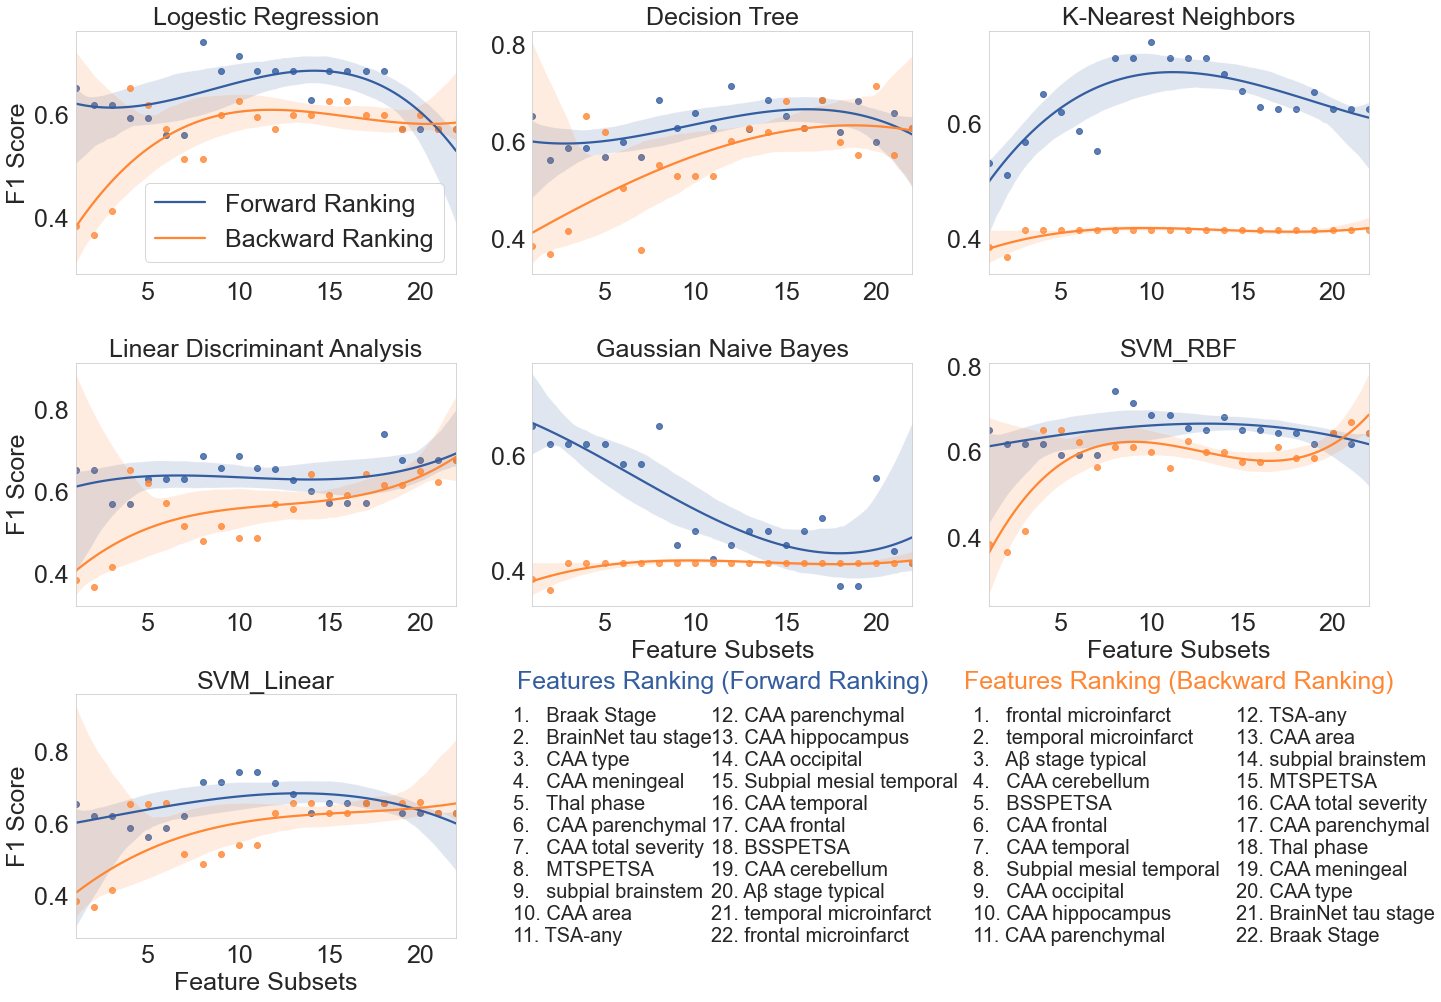

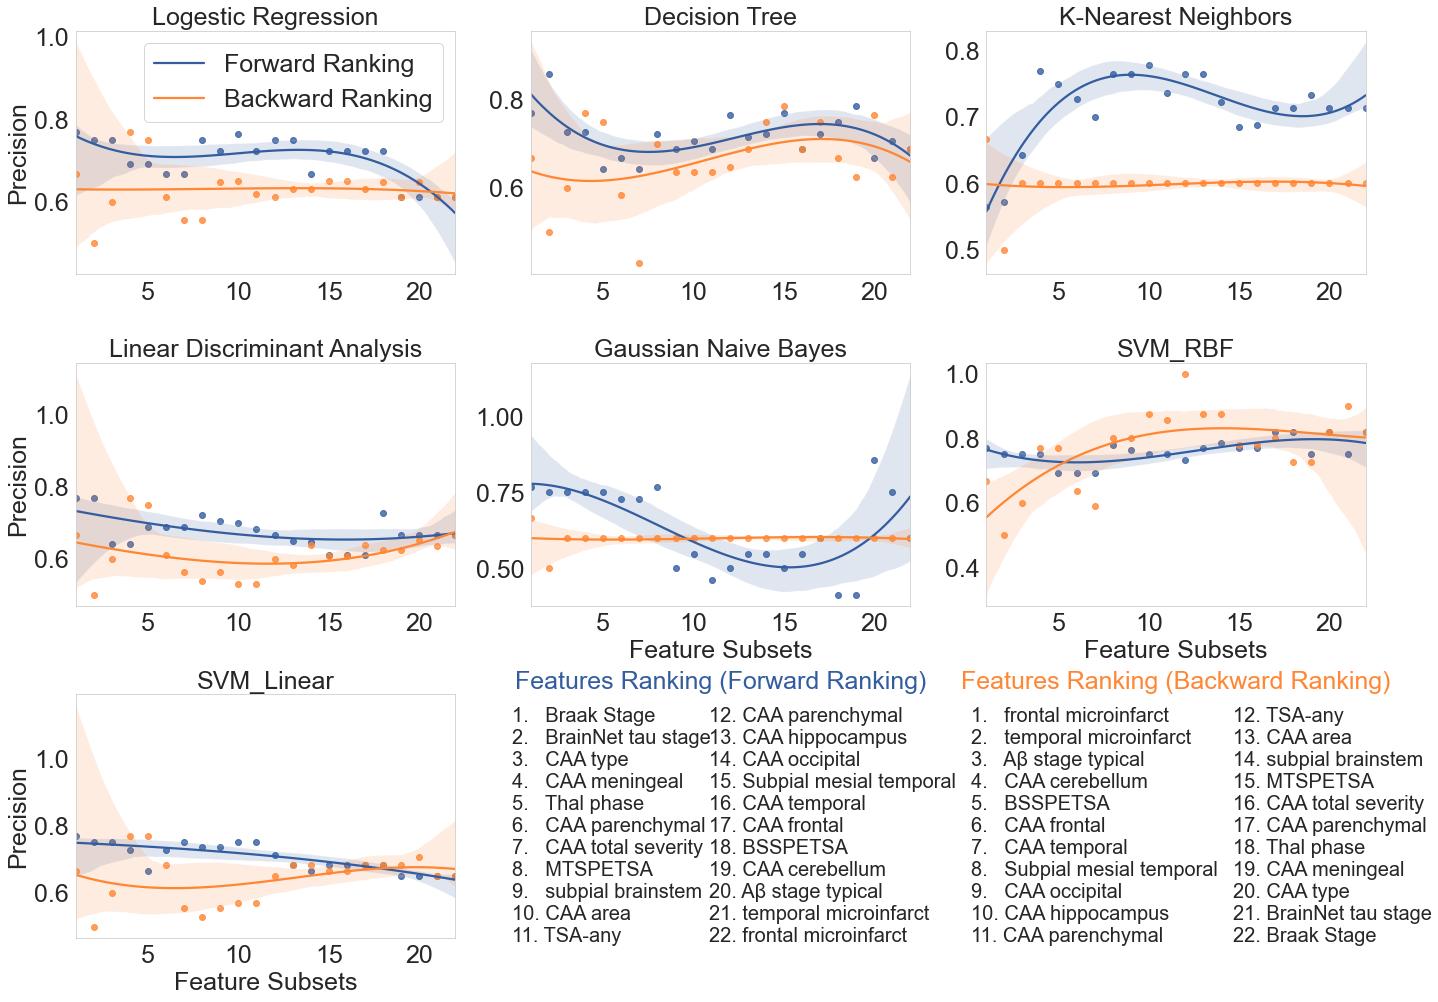

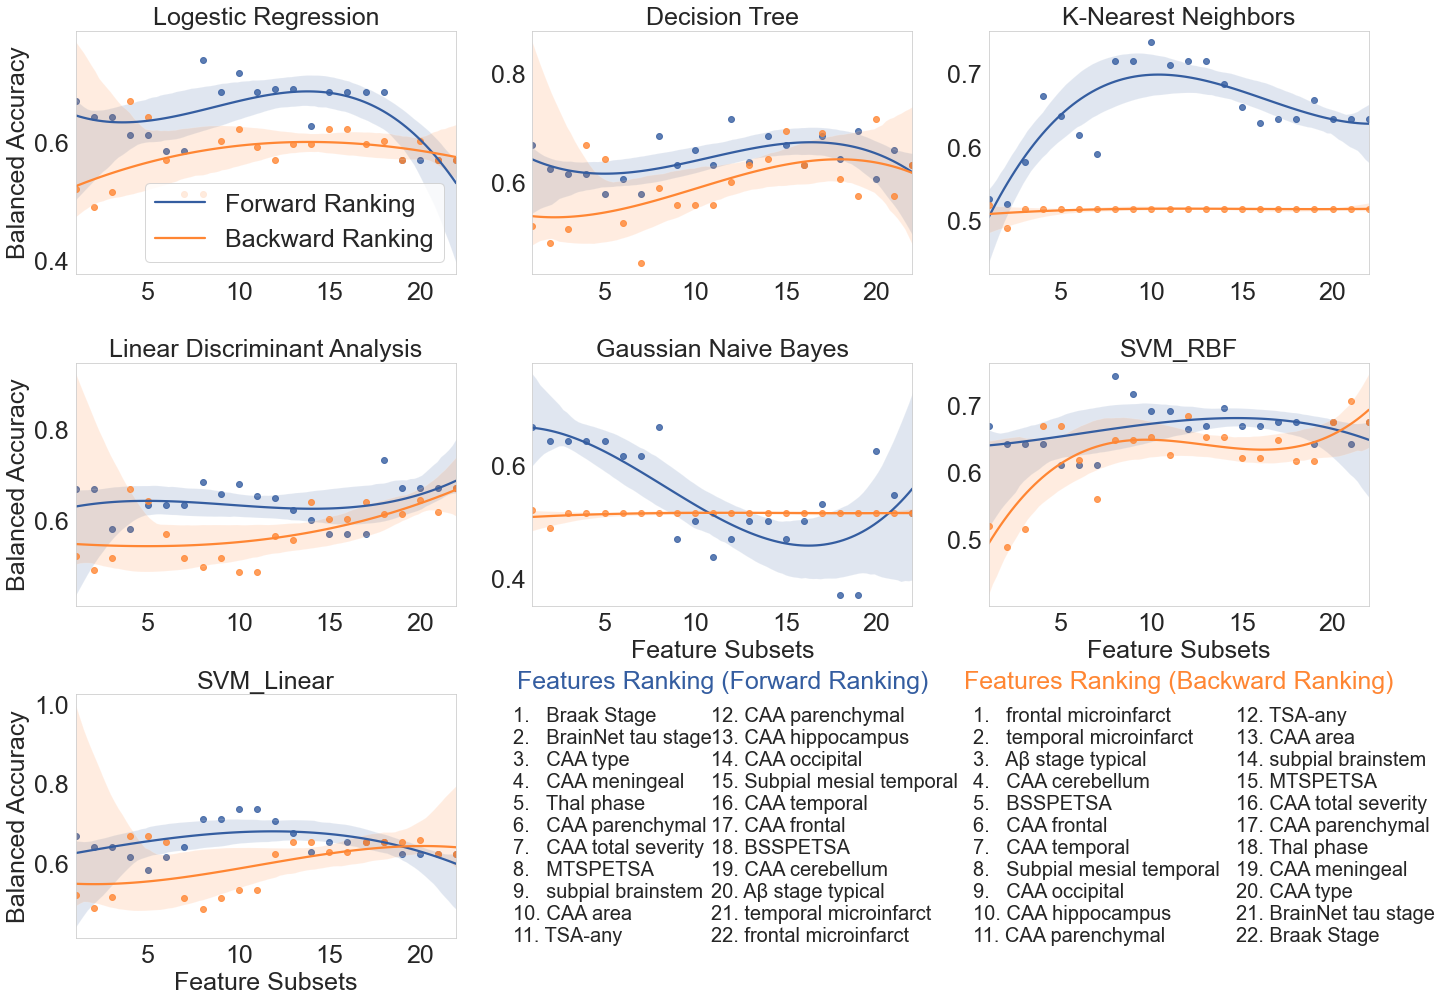

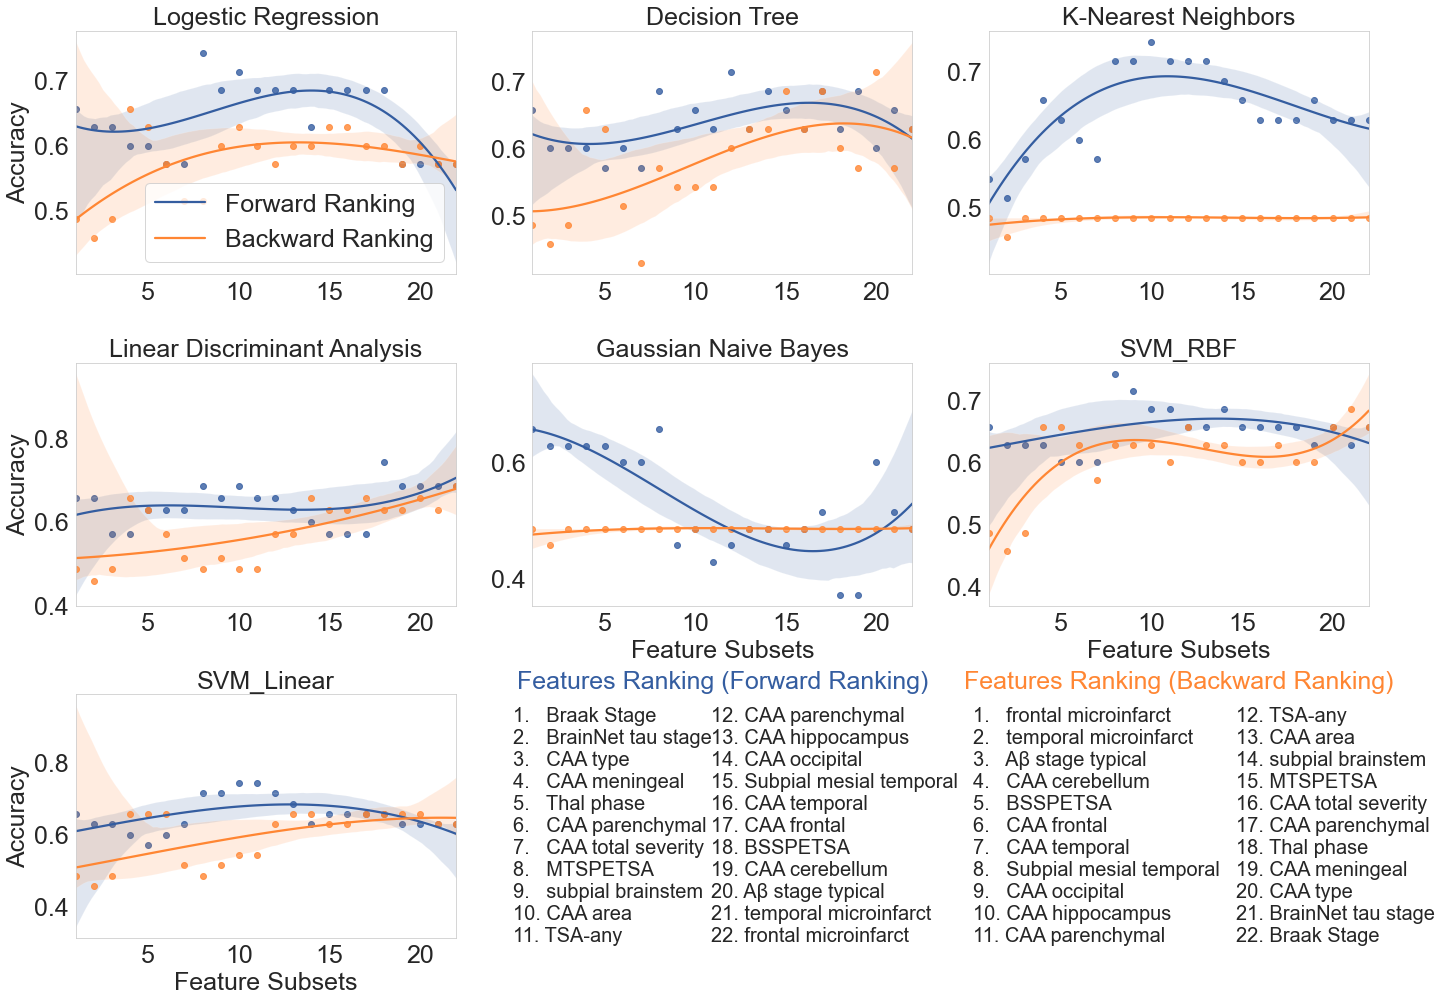

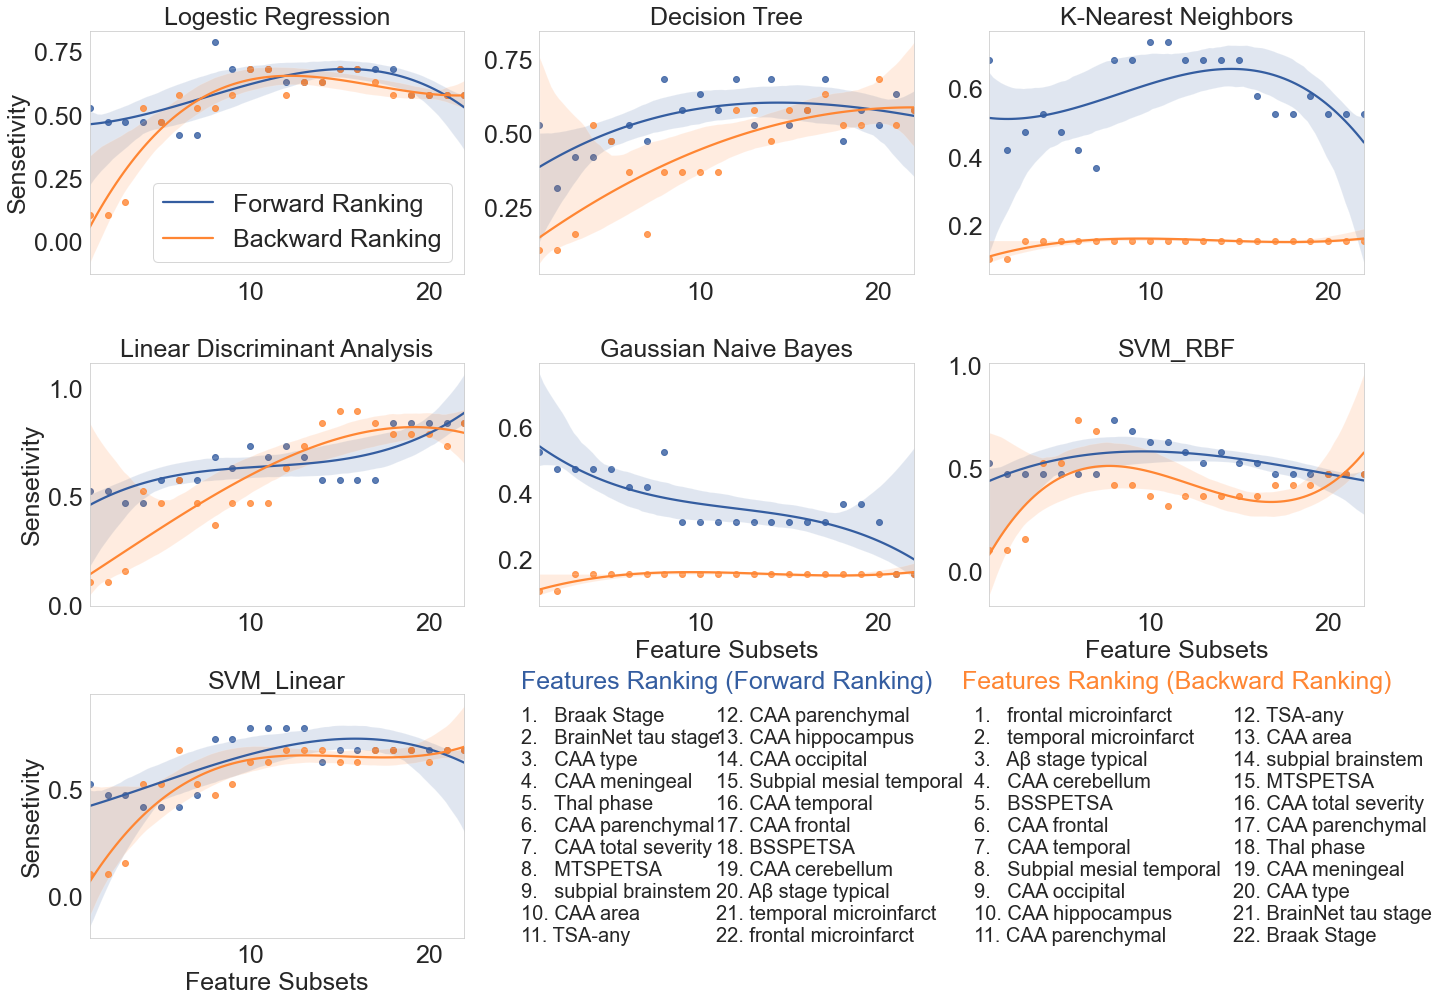

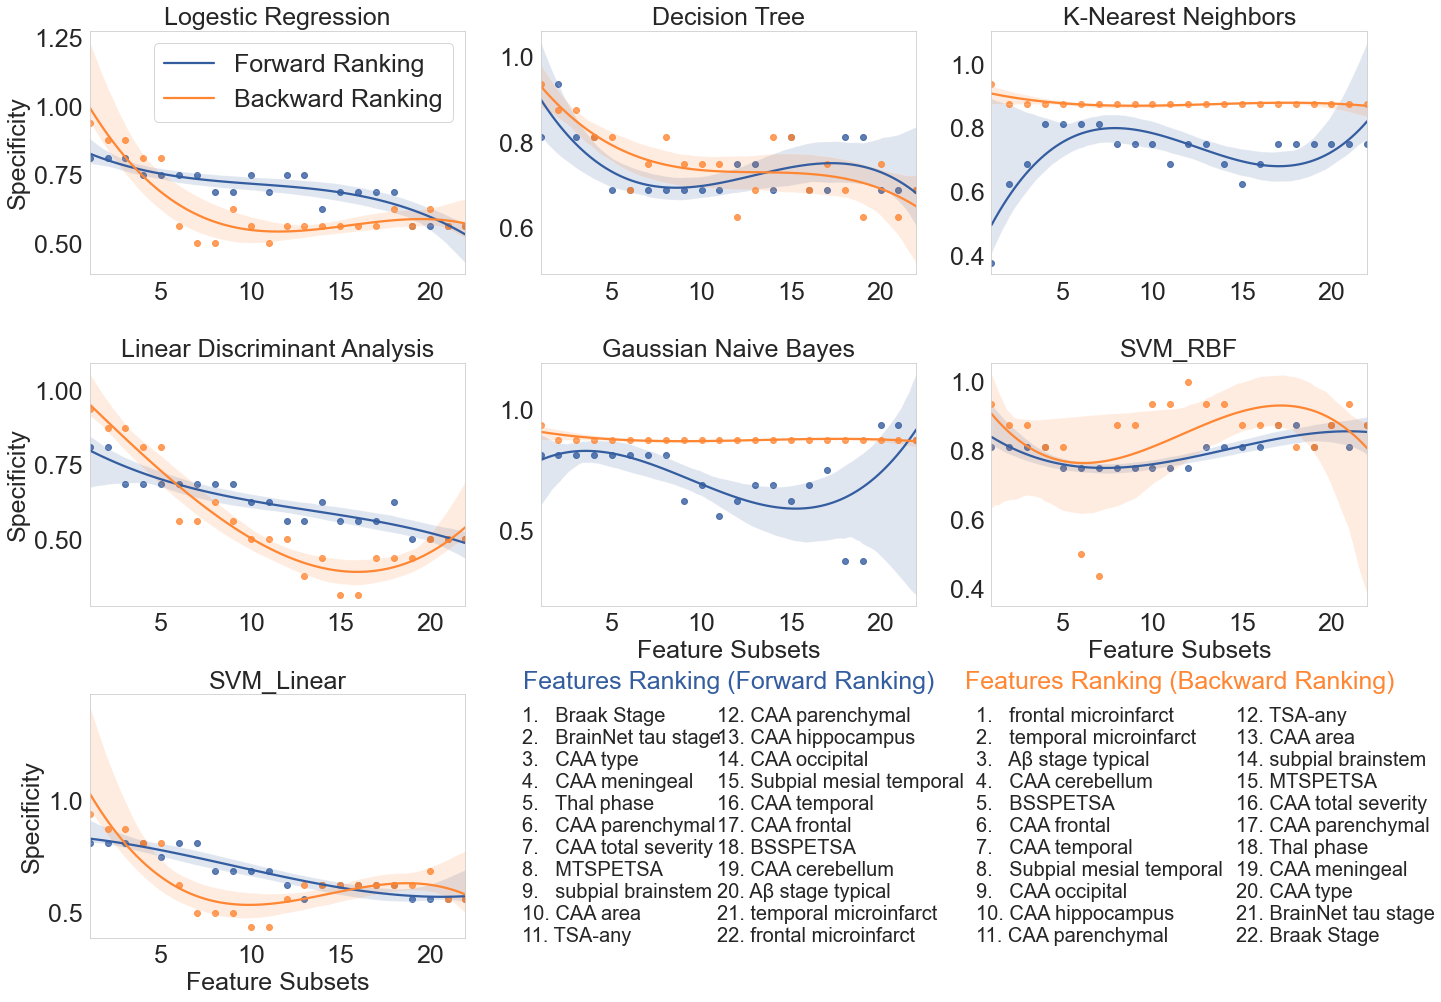

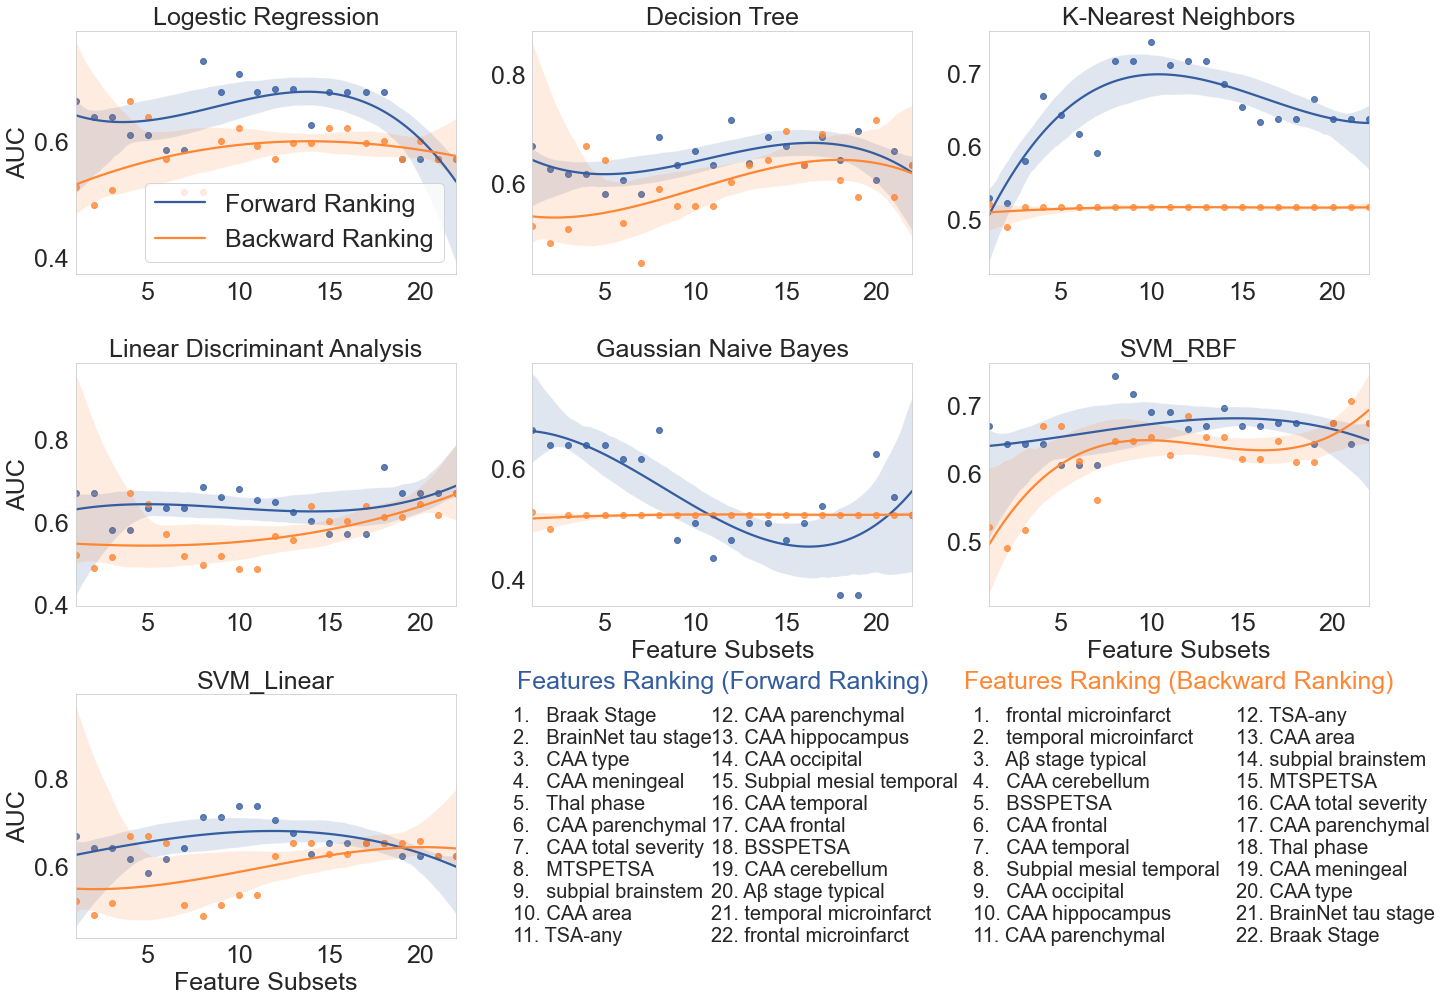

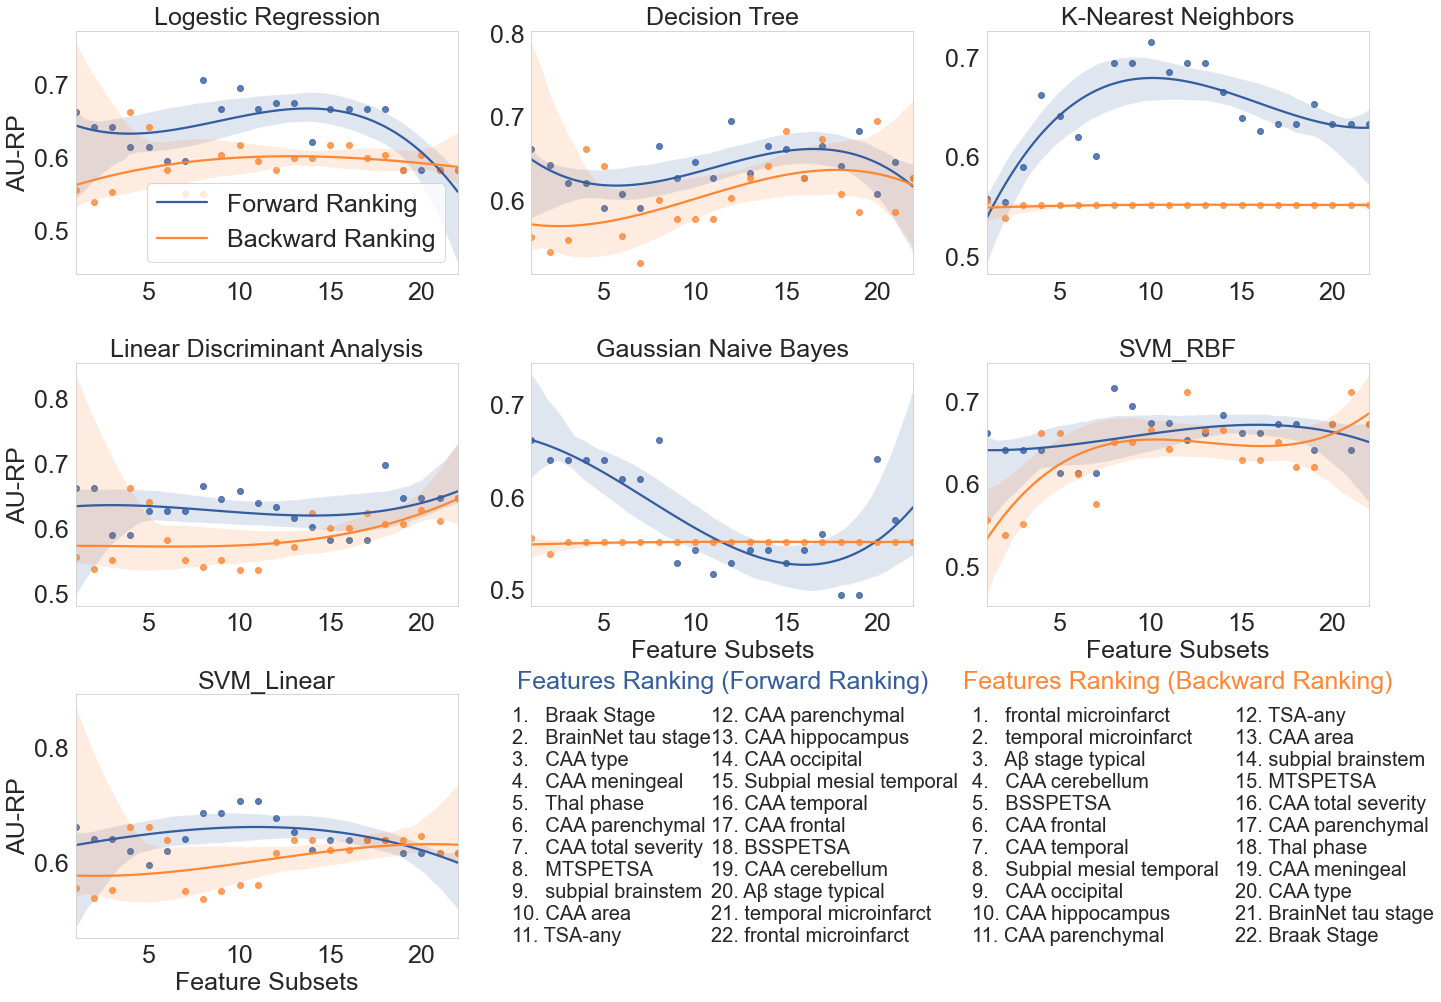

In [341]:
create_folder("Figures")
create_folder("Figures/measures")

ploting(new_balanced_no_AB, 'fscore', 'F1 Score')

ploting(new_balanced_no_AB, 'precision', 'Precision')

ploting(new_balanced_no_AB, 'balanced_acc', 'Balanced Accuracy')

ploting(new_balanced_no_AB, 'acc', 'Accuracy')

ploting(new_balanced_no_AB, 'sens', 'Sensetivity')

ploting(new_balanced_no_AB, 'spec', 'Specificity')

ploting(new_balanced_no_AB, 'auc', 'AUC')

ploting(new_balanced_no_AB, 'average_precision', 'AU-RP')